In [1]:
import sys
sys.path.append('../b_Temporal_Stack')
from eotempstack import *
from regionstack import *

In [17]:
saldana = regionStack('Saldana_training_2015', attrs=['S2','S1_ASCENDING'])

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 3 S2 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 8 S1 stack files


In [3]:
s2_xds = saldana.S2
s2_xds

<xarray.Dataset>
Dimensions:  (time: 8, x: 2979, y: 3631)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
    mask     (time, y, x) bool dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    NDVI     (time, y, x) float32 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    LSWI     (time, y, x) 

In [5]:
ndvi = saldana.S2.isel(time=0).NDVI

In [7]:
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np

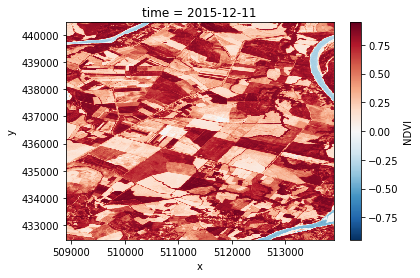

In [14]:
subset = saldana.S2.isel(time=0, x=slice(2000, 2500), y=slice(800, 1600))
subset.NDVI.plot()

In [10]:
# Get the rgb image for slic segmentation
rgb = subset.to_array().sel(variable=['red','green','blue']).transpose('x','y','variable').data
print('RGB shape: {}'.format(rgb.shape))
# Get the NDVI mask to use in watershed segmentation
ndvi = subset.NDVI.transpose('x','y').data
print('NDVI shape: {}'.format(ndvi.shape))

image = img_as_float(rgb/10000)

RGB shape: (500, 800, 3)
NDVI shape: (500, 800)


In [11]:
# Calculation of number of segments (empirically)
num_segments = (ndvi.shape[0] * ndvi.shape[1])/100

In [12]:
segments_slic = slic(img_as_float(rgb/10000), n_segments=num_segments, compactness=3)
segments_watershed = watershed(sobel(ndvi), markers=num_segments, compactness=0.001)

SLIC number of segments: 3519
Compact Watershed number of segments: 4000


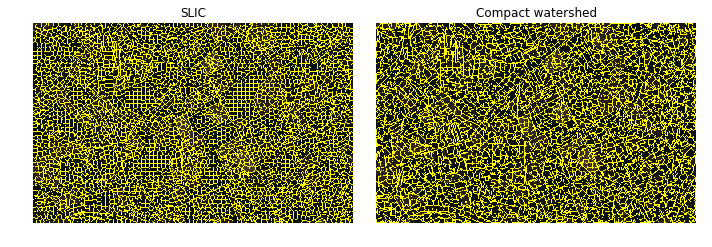

In [15]:
#http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Compact Watershed number of segments: {}'.format(len(np.unique(segments_watershed))))

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(mark_boundaries(image, segments_slic))
ax[0].set_title('SLIC')
ax[1].imshow(mark_boundaries(image, segments_watershed))
ax[1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [18]:
radar_subset = saldana.S1_ASCENDING.isel(time=0, x=slice(2000, 2500), y=slice(800, 1600))

In [19]:
# Create dummy array to compute stats
darray = np.array(radar_subset.VV.transpose('x','y').data.copy())
# New array for the zonal stats
stats_watershed = np.zeros((500, 800), dtype=float)
# Iterate over segments, compute and assign stat value to pixels in each segment
for segment in np.unique(segments_watershed):
    masked = np.ma.MaskedArray(darray, mask=np.logical_not(segments_watershed==segment))
    np.place(stats_watershed, segments_watershed==segment, masked.mean())

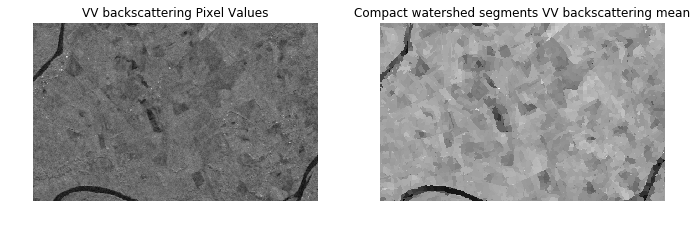

In [20]:
# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(darray, cmap='gray')
ax[0].set_title('VV backscattering Pixel Values')
ax[1].imshow(stats_watershed, cmap='gray')
ax[1].set_title('Compact watershed segments VV backscattering mean')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()